In [2]:
from astropy.io import fits
import os
from astropy.table import Table
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from uncertainties import unumpy as unp
from uncertainties import correlated_values
from astroquery.gaia import Gaia
from astroquery.irsa import Irsa
import astropy.units as u
from astropy.coordinates import SkyCoord

C:\Users\gordo\AppData\Local\Temp\ipykernel_14652\1110961582.py:12: DeprecationWarning: the ``irsa`` module has been moved to astroquery.ipac.irsa, please update your imports.
  from astroquery.irsa import Irsa


Link to GitHub repository: https://github.com/gor195/Astronomical-Computing/tree/Assignment-3

# Task 2

In [3]:
# Query just Gaia DR3 for stars within 1 degree of the centre of M67 and brighter than G=14
query = f"""
SELECT *
FROM gaiadr3.gaia_source AS gaia
WHERE DISTANCE(POINT(132.825, 11.8), POINT(gaia.ra, gaia.dec)) < 1.0
AND gaia.phot_g_mean_mag < 14.0
"""
# Upload the 2MASS coordinates table for crossmatching
job = Gaia.launch_job_async(query=query)
gaiadr3_match = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [4]:
gaiadr3_match

solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,log(cm.s**-2),dex,,km / s,km / s,,mag,mag,,,,deg,deg,deg,deg,,,,,,,,,,,,,,,K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,

In [5]:
# Query 2MASS data around M67
twomass_data = Irsa.query_region(SkyCoord(ra=132.825*u.degree, dec=11.8*u.degree), catalog="fp_psc", spatial="Cone", radius=1*u.degree)

In [6]:
twomass_data

ra,dec,clon,clat,err_maj,err_min,err_ang,designation,j_m,j_cmsig,j_msigcom,j_snr,h_m,h_cmsig,h_msigcom,h_snr,k_m,k_cmsig,k_msigcom,k_snr,ph_qual,rd_flg,bl_flg,cc_flg,ndet,gal_contam,mp_flg,hemis,xdate,scan,glon,glat,a,dist_opt,phi_opt,b_m_opt,vr_m_opt,nopt_mchs,ext_key,dist,angle,j_h,h_k,j_k
deg,deg,,,arcsec,arcsec,deg,,mag,mag,mag,,mag,mag,mag,,mag,mag,mag,,,,,,,,,,,,deg,deg,,arcsec,deg,mag,mag,,,arcsec,deg,,,
float64,float64,object,object,float64,float64,int32,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,int32,int32,object,object,int32,float64,float64,object,float64,int32,float64,float64,int32,int32,float64,float64,float64,float64,float64
133.068005,11.960207,08h52m16.32s,11d57m36.75s,0.11,0.11,55,08521632+1157367,16.073,0.067,0.068,14.4,15.333,0.090,0.090,12.2,15.428,0.163,0.163,7.0,AAC,222,111,000,061605,0,0,n,2000-02-16,43,215.642,32.179,U,0.6,198,18.10,17.20,1,--,1032.234068,56.006693,0.74,-0.095,0.645
133.062072,11.977266,08h52m14.90s,11d58m38.16s,0.13,0.12,92,08521489+1158381,16.270,0.089,0.090,12.0,15.515,0.109,0.109,10.3,15.286,0.146,0.146,8.0,ABB,222,111,000,060606,0,0,n,2000-02-16,43,215.621,32.181,0,--,--,--,--,0,--,1051.0585,52.591421,0.755,0.229,0.984
133.041034,12.005770,08h52m09.85s,12d00m20.77s,0.31,0.29,14,08520984+1200207,17.089,0.168,0.168,5.9,16.446,0.222,0.222,4.5,16.099,0.240,0.240,4.2,CDD,222,111,000,060606,0,0,n,1997-11-15,132,215.580,32.174,0,--,--,--,--,0,--,1062.009344,45.749475,0.643,0.347,0.99
133.049246,11.997709,08h52m11.82s,11d59m51.75s,0.11,0.06,0,08521181+1159517,13.462,0.020,0.024,165.1,13.210,0.026,0.027,89.1,13.087,0.026,0.028,67.1,AAA,222,111,000,666666,0,0,n,1997-11-15,132,215.592,32.178,U,0.4,230,15.00,13.90,1,--,1063.294513,47.957405,0.252,0.123,0.375
133.025264,12.029343,08h52m06.06s,12d01m45.63s,0.11,0.06,0,08520606+1201456,14.257,0.025,0.028,79.4,13.801,0.032,0.033,51.7,13.665,0.033,0.034,39.4,AAA,222,111,000,666666,0,0,n,1997-11-15,132,215.547,32.170,U,0.7,239,16.70,15.30,1,--,1085.949862,40.489791,0.456,0.136,0.592
133.018306,12.037612,08h52m04.39s,12d02m15.40s,0.18,0.18,17,08520439+1202154,16.379,0.103,0.104,11.2,15.786,0.152,0.152,8.3,15.750,--,--,--,ABU,220,110,000,062400,0,0,n,1997-11-15,132,215.535,32.167,U,1.0,196,17.70,16.90,1,--,1093.314722,38.499788,0.593,--,--
133.018885,12.038982,08h52m04.53s,12d02m20.34s,0.21,0.17,180,08520453+1202203,16.708,0.128,0.129,8.3,15.836,0.132,0.133,7.9,15.548,0.151,0.151,7.0,BBC,222,111,c00,060406,0,0,n,1997-11-15,132,215.533,32.168,U,4.4,24,17.70,16.90,1,--,1098.44355,38.422672,0.872,0.288,1.16
133.003925,12.051920,08h52m00.94s,12d03m06.91s,0.17,0.14,2,08520094+1203069,16.218,0.080,0.081,13.0,15.615,0.120,0.120,9.7,15.108,0.100,0.100,10.4,ABA,222,111,000,160405,0,0,n,1997-11-15,132,215.512,32.161,U,0.8,238,19.90,18.60,1,--,1104.388695,34.777572,0.603,0.507,1.11


In [7]:
# Prepare the 2MASS data with coordinates for crossmatching
twomass_coords = SkyCoord(twomass_data['ra'], twomass_data['dec'], unit=(u.deg, u.deg))
twomass_source_ids_table = Table([twomass_data['ph_qual'], twomass_data['j_m'], twomass_data['k_m'], twomass_data['ra'], twomass_data['dec']], names=['ph_qual', 'j_m', 'k_m', 'ra', 'dec'])
print(twomass_source_ids_table)

ph_qual  j_m    k_m       ra        dec    
         mag    mag      deg        deg    
------- ------ ------ ---------- ----------
    AAC 16.073 15.428 133.068005  11.960207
    ABB 16.270 15.286 133.062072  11.977266
    CDD 17.089 16.099 133.041034  12.005770
    AAA 13.462 13.087 133.049246  11.997709
    AAA 14.257 13.665 133.025264  12.029343
    ABU 16.379 15.750 133.018306  12.037612
    BBC 16.708 15.548 133.018885  12.038982
    ABA 16.218 15.108 133.003925  12.051920
    ABC 16.263 15.487 133.075503  11.986448
    ...    ...    ...        ...        ...
    AAA 14.452 13.637 133.545208  11.947006
    BUU 16.554 15.709 133.554804  11.907258
    AAA 14.649 13.961 133.562856  11.863834
    AAA 14.575 14.127 133.562405  11.947103
    AAA 15.335 14.519 133.569174  11.943874
    AAA 15.782 14.981 133.572522  11.942344
    AAA 14.792 14.415 133.577236  11.927119
    AAB 15.514 15.088 133.592891  11.924237
    AAA 15.139 14.342 133.596603  11.944457
    CCU 16.669 15.498 133.615499

In [8]:
# Since the 2MASS catalog doesn't have a source_id column, we can crossmatch using the coordinates.
# We can select a crossmatching radius for each source and I have chosen 0.003 degrees since the ra of M67 is correct to three decimal places.
# This radius is chosen to account for differences in exact positions of sources between catalogs.
query = f"""
SELECT *
FROM gaiadr3.gaia_source AS gaia
JOIN TAP_UPLOAD.t1 AS twomass
ON 1=CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), CIRCLE('ICRS', twomass.ra, twomass.dec, 0.003))
WHERE DISTANCE(POINT(132.825, 11.8), POINT(gaia.ra, gaia.dec)) < 1
AND gaia.phot_g_mean_mag < 14.0
"""
# Upload the 2MASS coordinates table for crossmatching
job = Gaia.launch_job_async(query=query, upload_resource=twomass_source_ids_table, upload_table_name="t1")
gaiadr3_match = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [9]:
gaiadr3_match

solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,ph_qual,j_m,k_m,ra_2,dec_2
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,log(cm.s**-2),dex,,km / s,km / s,,mag,mag,,,,deg,deg,deg,deg,,,,,,,,,,,,,,,K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,,---,mag,mag,deg,deg
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,f

We get 1029 matches just from Gaia DR3 and 500 from just 2MASS. When we crossmatch the two catalogs within 0.003 degrees or approximately 10 arcseconds, we get 43 stars.

In [10]:
query = f"""
SELECT *
FROM gaiadr3.gaia_source AS gaia
JOIN TAP_UPLOAD.t1 AS twomass
ON 1=CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), CIRCLE('ICRS', twomass.ra, twomass.dec, 0.003))
WHERE DISTANCE(POINT(132.825, 11.8), POINT(gaia.ra, gaia.dec)) < 1
AND gaia.phot_g_mean_mag < 14.0
AND twomass.ph_qual = 'AAA'
"""
# Upload the 2MASS coordinates table for crossmatching
job = Gaia.launch_job_async(query=query, upload_resource=twomass_source_ids_table, upload_table_name="t1")
gaiadr3_match = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


There were 4 stars with bad 2MASS photometry.

In [11]:
gaiadr3_match

solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,ph_qual,j_m,k_m,ra_2,dec_2
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,log(cm.s**-2),dex,,km / s,km / s,,mag,mag,,,,deg,deg,deg,deg,,,,,,,,,,,,,,,K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,,---,mag,mag,deg,deg
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,f

In [22]:
query = f"""
SELECT *
FROM gaiadr3.gaia_source AS gaia
JOIN TAP_UPLOAD.t1 AS twomass
ON 1=CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), CIRCLE('ICRS', twomass.ra, twomass.dec, 0.003))
WHERE DISTANCE(POINT(132.825, 11.8), POINT(gaia.ra, gaia.dec)) < 1
AND gaia.phot_g_mean_mag < 14.0
AND twomass.ph_qual = 'AAA'
AND gaia.parallax > 0
"""
# Upload the 2MASS coordinates table for crossmatching
job = Gaia.launch_job_async(query=query, upload_resource=twomass_source_ids_table, upload_table_name="t1")
gaiadr3_match = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


There were no stars with negative parallaxes in the Gaia data. After these two cuts there are 39 stars remaining.

In [23]:
gaiadr3_match

solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,ph_qual,j_m,k_m,ra_2,dec_2
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,log(cm.s**-2),dex,,km / s,km / s,,mag,mag,,,,deg,deg,deg,deg,,,,,,,,,,,,,,,K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,,---,mag,mag,deg,deg
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,f

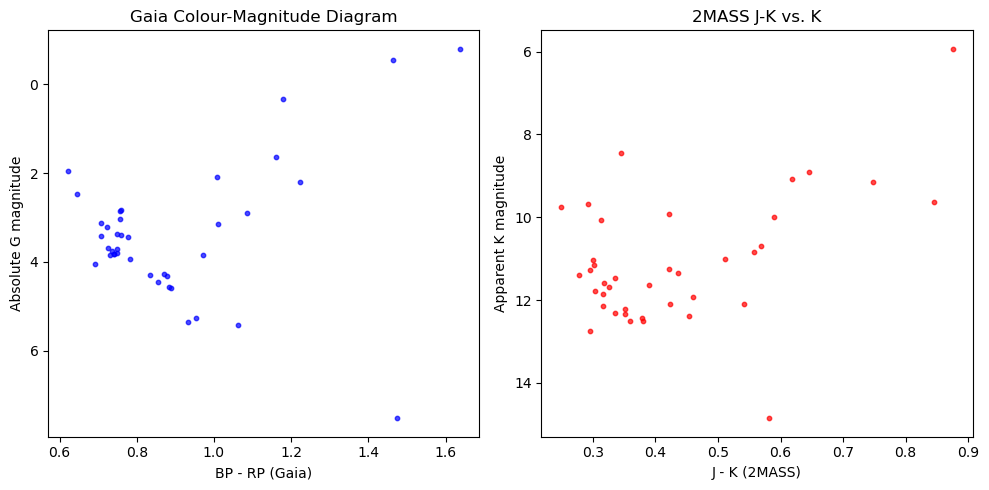

In [24]:
# Calculate distance in parsecs
distance_pc = 1000.0 / gaiadr3_match['parallax']

# Calculate the absolute G magnitude
absolute_g = gaiadr3_match['phot_g_mean_mag'] - 5 * np.log10(distance_pc) + 5

# Calculate color index J-Ks
j_ks = gaiadr3_match['j_m'] - gaiadr3_match['k_m']

# Set up the figure with two panels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Panel (a): Gaia CMD (BP-RP vs. Absolute G magnitude)
ax1.scatter(gaiadr3_match['bp_rp'], absolute_g, s=10, c='blue', alpha=0.7)
ax1.set_xlabel('BP - RP (Gaia)')
ax1.set_ylabel('Absolute G magnitude')
ax1.set_title('Gaia Colour-Magnitude Diagram')
ax1.invert_yaxis()  # To have the brightest stars at the top

# Panel (b): 2MASS J-Ks vs. apparent Ks magnitude
ax2.scatter(j_ks, gaiadr3_match['k_m'], s=10, c='red', alpha=0.7)
ax2.set_xlabel('J - K (2MASS)')
ax2.set_ylabel('Apparent K magnitude')
ax2.set_title('2MASS J-K vs. K')
ax2.invert_yaxis()  # To have the brightest stars at the top

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('figures\cmds_M67.png', dpi=200)

# Show the plot
plt.show()

There are only a small number of stars in the vicinity of M67 that are in both data sets and are bright enough and this may lead to inefficient fibre usage and a higher risk of not achieving observational goals. The number of targets has however been limited by the crossmatching method since the two catalogs did not share source IDs. The colleague could also increase the search radius.

# Task 3

Downloading the file from the link into data/

In [15]:
# Check if 'data' directory exists, if not, create it
if not os.path.exists('data'):
    os.makedirs('data')

# You can also check if a specific file exists
file_path = 'data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits'

if not os.path.exists(file_path):
    try:
        # Download the file from a URL, if it does not exist
        import wget
        wget.download(
            url='https://github.com/svenbuder/astr4004_2024_week7/blob/main/data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits',
            out=file_path
        )
    except Exception as e:
        raise RuntimeError(f"Could not download FITS file: {e}")

In [16]:
# Load the FITS file
with fits.open('data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits') as hdul:
    # Assuming the data is in the first HDU
    data = hdul[1].data

# Preview the data columns
print(data.columns)

xdata = data['x']
ydata = data['y']
zdata = data['z']
AO_data = data['A_O']

# Calculating Galactocentric radius of points from their 3D positions
R_Gal = np.sqrt(xdata**2 + ydata**2 + zdata**2)

ColDefs(
    name = 'x'; format = 'E'
    name = 'y'; format = 'E'
    name = 'z'; format = 'E'
    name = 'A_O'; format = 'D'
)


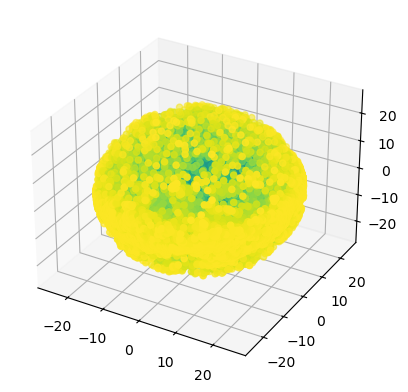

In [17]:
# Plotting the positions of each point and each coloured by their Galactocentric radius.
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(xdata, ydata, zdata, c=R_Gal, cmap='viridis')

Intercept = 9.122319362998459 ± 0.00028246700912770446
Slope = -0.033250273606796776 ± 1.774130833279467e-05
Error function: 3923.503961860561
RMSE: 0.08758


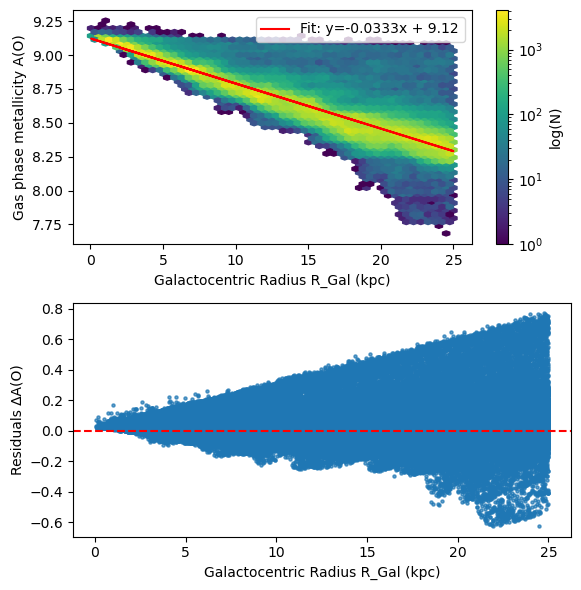

In [18]:
#Linear fit on R_Gal vs. A(O)
#Define a linear function for the fit
def linear_fit(slope, intercept, R_Gal):
    return slope*R_Gal+intercept

params, covariance_matrix = curve_fit(linear_fit, R_Gal, AO_data) # the param gives the best estimated parameters
# and the covariance matrix gives the full error matrix of the estimated parameters

uncertainties = np.sqrt(np.diag(covariance_matrix))
error = ((AO_data - linear_fit(R_Gal, *params))**2).sum() # the total error between the best fitted model and the data

# Get the correlated parameters with uncertainties
param_values = correlated_values(params, covariance_matrix)

# Generate the best-fit line
y_fit = linear_fit(R_Gal, *params)

# Propagate the uncertainties to the model
y_uncert = linear_fit(R_Gal, *param_values)
nominal_values = unp.nominal_values(y_uncert)
std_devs = unp.std_devs(y_uncert)

print('Intercept = {} ± {}'.format(params[0], uncertainties[0]))
print('Slope = {} ± {}'.format(params[1], uncertainties[1]))
print('Error function: {}'.format(error))

#Calculate residuals and RMSE
AO_fit = linear_fit(R_Gal, params[0], params[1])
residuals = AO_data - AO_fit
rmse = np.sqrt(mean_squared_error(AO_data, AO_fit))
print(f"RMSE: {rmse:.5f}")

#Create a 2-panel figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
# Panel 1: Logarithmic density plot of R_Gal vs A(O)
hb = ax1.hexbin(R_Gal, AO_data, gridsize=50, cmap='viridis', bins='log')
ax1.plot(R_Gal, AO_fit, 'r', label=f'Fit: y=-0.0333x + 9.12')
ax1.set_xlabel('Galactocentric Radius R_Gal (kpc)')
ax1.set_ylabel('Gas phase metallicity A(O)')
ax1.legend()
cb = fig.colorbar(hb, ax=ax1)
cb.set_label('log(N)')

# Panel 2: Residuals plot (R_Gal vs ∆A(O))
ax2.scatter(R_Gal, residuals, s=5, alpha=0.7)
ax2.axhline(0, color='red', linestyle='--')
ax2.set_xlabel('Galactocentric Radius R_Gal (kpc)')
ax2.set_ylabel('Residuals ∆A(O)')

plt.tight_layout()
plt.savefig('figures/logarithmic_density_plot.png')
plt.show()

In [19]:
# Calculate the total sum of squares (variance of the data)
SS_tot = np.sum((AO_data - np.mean(AO_data))**2)

# Calculate the residual sum of squares
SS_res = np.sum(residuals**2)

# Calculate R^2
R_squared = 1 - (SS_res / SS_tot)

# Output the result
print(f"R Squared: {R_squared:.4f}")

R Squared: 0.8729


As seen the linear model has a negative slope so gas phase metallicity decreases as the distance from the Galactic centre increases.

The R sqaured value indicates that about 87% of the variance in the data is explained by the linear model. This suggests that the linear model captures the overall trend of decreasing metallicity with increasing radius fairly well.

No hyperparameters were used for the fitting

The linear models fits well close to the centre of the galaxy, but this decreases as you go further out/as the galactocentric radius increases as shown by the residuals plot. 

If all the points lie on the linear regression line that RMSE would be zero. While the RMSE is not zero, it is still a small number meaning that there is little error in using the linear model.

Doing this just for the regions with higher residuals:

In [20]:
# Calculate the residuals
residuals = AO_data - AO_fit

# Define a residual threshold (for example, residuals greater than 0.2 or below -0.2)
threshold = 0.2

# Select the regions with higher residuals
high_residual_mask = np.abs(residuals) > threshold

# Isolate the high residual data points
R_Gal_high_residuals = R_Gal[high_residual_mask]
A_O_high_residuals = AO_data[high_residual_mask]

# Perform linear fit
params_high_residuals, params_covariance_high_residuals = curve_fit(linear_fit, R_Gal_high_residuals, A_O_high_residuals)

# Get the predicted values based on the new fit
A_O_fit_high_residuals = linear_fit(R_Gal_high_residuals, *params_high_residuals)

# Calculate R^2 for high residuals region
SS_tot_high = np.sum((A_O_high_residuals - np.mean(A_O_high_residuals))**2)
SS_res_high = np.sum((A_O_high_residuals - A_O_fit_high_residuals)**2)
R_squared_high_residuals = 1 - (SS_res_high / SS_tot_high)

# Calculate RMSE for high residuals region
RMSE_high_residuals = np.sqrt(np.mean((A_O_high_residuals - A_O_fit_high_residuals)**2))

# Output the results
print(f"Linear Fit Parameters for High Residuals Region: slope = {params_high_residuals[1]:.4f}, intercept = {params_high_residuals[0]:.4f}")
print(f"R Squared for High Residuals Region: {R_squared_high_residuals:.4f}")
print(f"RMSE for High Residuals Region: {RMSE_high_residuals:.4f}")

Linear Fit Parameters for High Residuals Region: slope = -0.0340, intercept = 9.3622
R Squared for High Residuals Region: 0.2326
RMSE for High Residuals Region: 0.2723


R Squared indicates that only 23% of the variance in the high residuals regions is explained by the linear model.

The RMSE is a much higher number meaning that there is more error in the linear model and less points lie on the linear regression line.

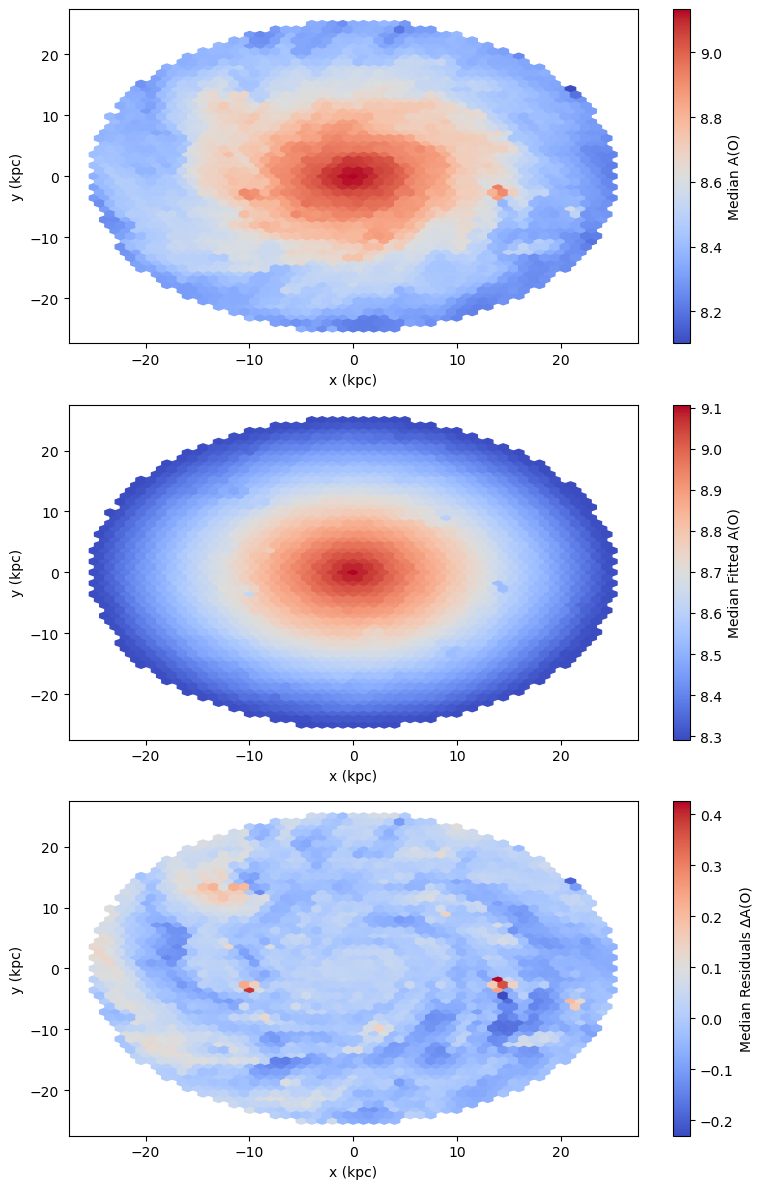

In [21]:
#3-Panel Figure for x vs y plane with median A(O)
bins = 50

# 2D-histogram for median simulated A(O)
fig, (ax3, ax4, ax5) = plt.subplots(3, 1, figsize=(8, 12))

#Simulated A(O)
# 2D hexagonal binning plot of points with AO specifing values at each set of coordinates. For each hexagon these values are reduced by the median.
hb_sim = ax3.hexbin(data['x'], data['y'], C=AO_data, gridsize=bins, cmap='coolwarm', reduce_C_function=np.median)
ax3.set_xlabel('x (kpc)')
ax3.set_ylabel('y (kpc)')
cb = fig.colorbar(hb_sim, ax=ax3)
cb.set_label('Median A(O)')

#Fitted A(O)
hb_fit = ax4.hexbin(data['x'], data['y'], C=AO_fit, gridsize=bins, cmap='coolwarm', reduce_C_function=np.median)
ax4.set_xlabel('x (kpc)')
ax4.set_ylabel('y (kpc)')
cb = fig.colorbar(hb_fit, ax=ax4)
cb.set_label('Median Fitted A(O)')

#Residuals
hb_res = ax5.hexbin(data['x'], data['y'], C=residuals, gridsize=bins, cmap='coolwarm', reduce_C_function=np.median)
ax5.set_xlabel('x (kpc)')
ax5.set_ylabel('y (kpc)')
cb = fig.colorbar(hb_res, ax=ax5)
cb.set_label('Median Residuals ∆A(O)')

plt.tight_layout()
plt.savefig('figures/median_2d_histograms.png')
plt.show()

For too little bins most features of the data are lost and variation in the the gas phase metallicity could be averaged out which leaves a misleading representation. For too many bins the computing time is longer and it can result in overfitting. The histogram could also highlight the noise in the data and overcomplicate the distribution making it harder to see patterns. I chose 50 bins which is a good balance between the two visually.

Variations in the residuals is visually due to the spiral arms of the galaxy and this increases as distance increases from the centre of the galaxy. This makes sense as we would expect metallicity to be greater in the centre and in spiral arms as this is where star formation and supernova feedback is highest. The little variations and pockets of high metallicity on the spiral arms could be due to supernovae, or gas flows.